In [ ]:
!pip install opencv-python
!pip install mediapipe
!pip install scikit-learn

# 1. Importing libraries and defining dataset

In [1]:
# For capturing hand coordinates
import cv2
import mediapipe as mp

# For processing data
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('./Dataset/hand_dataset_1000_24.csv')

# Show dataset first five data
dataset.head()

,class,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x17,y17,x18,y18,x19,y19,x20,y20,x21,y21
0,A,0.295849,0.679613,0.209038,0.612926,0.147883,0.522415,0.125748,0.439133,0.130589,...,0.295946,0.572083,0.362726,0.507097,0.362393,0.452241,0.351849,0.504388,0.340516,0.553928
1,A,0.277914,0.728127,0.168684,0.634556,0.107125,0.489586,0.104561,0.368203,0.126103,...,0.284394,0.614332,0.458914,0.482608,0.402338,0.455794,0.359927,0.538472,0.352813,0.605610
2,A,0.273304,0.750424,0.153818,0.649119,0.087932,0.492969,0.090790,0.370735,0.114260,...,0.292044,0.643904,0.450758,0.495144,0.392497,0.475129,0.353110,0.558542,0.348972,0.624010
3,A,0.260779,0.758578,0.142449,0.658145,0.081542,0.496756,0.090102,0.373770,0.115699,...,0.282037,0.659344,0.449754,0.502502,0.380867,0.484203,0.343782,0.567716,0.341316,0.632237
4,A,0.264733,0.761643,0.144033,0.670212,0.077731,0.505519,0.080886,0.379795,0.101522,...,0.289165,0.674617,0.432672,0.504809,0.386974,0.488224,0.355972,0.573528,0.350644,0.638745


In [3]:
# Show dataset overview, should return 1000 for each alphabet (excluding y and z)
dataset['class'].value_counts()

K    1000
D    1000
X    1000
S    1000
G    1000
U    1000
R    1000
A    1000
Q    1000
N    1000
V    1000
P    1000
E    1000
W    1000
H    1000
T    1000
M    1000
I    1000
L    1000
O    1000
F    1000
B    1000
Y    1000
C    1000
Name: class, dtype: int64

# 2. Creating Train and Test Data
- We use *train_test_split* since we don't really have test dataset.
- Normalizing dataset can be ignored, since we predict our data directly using raw handlandmark. 

In [4]:
# Defining X and Y from dataset for training and testing

X = dataset.iloc[:, 1:].values
Y = dataset.iloc[:, 0].values

In [5]:
from sklearn.model_selection import train_test_split

# We will take 33% from 1000 for our test data.
# Recommended value 80:20, 67:33, 50:50
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [6]:
#Normalize / Standarize dataset

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 3. Creating classifier model for our alphabet recognition.
- *n_neighbors* can be adjusted as we provide graph for mean errors for each *n_neighbors*

In [7]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

# 4. Calculate model accuracy

In [8]:
y_pred = classifier.predict(X_test)

In [9]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.93      0.99      0.96       297
           B       0.96      0.99      0.97       325
           C       0.97      0.99      0.98       335
           D       0.98      0.97      0.97       339
           E       0.93      0.97      0.95       320
           F       0.98      0.98      0.98       316
           G       0.98      0.99      0.98       361
           H       0.98      0.99      0.99       328
           I       0.97      0.97      0.97       343
           K       0.94      0.98      0.96       332
           L       0.98      0.98      0.98       330
           M       0.85      0.84      0.84       311
           N       0.85      0.84      0.85       332
           O       0.97      0.93      0.95       339
           P       0.96      0.94      0.95       327
           Q       0.94      0.96      0.95       322
           R       0.90      0.91      0.91       321
           S       0.93    

# 5. Show graph for adjusting number of *n_neighbors*

In [10]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

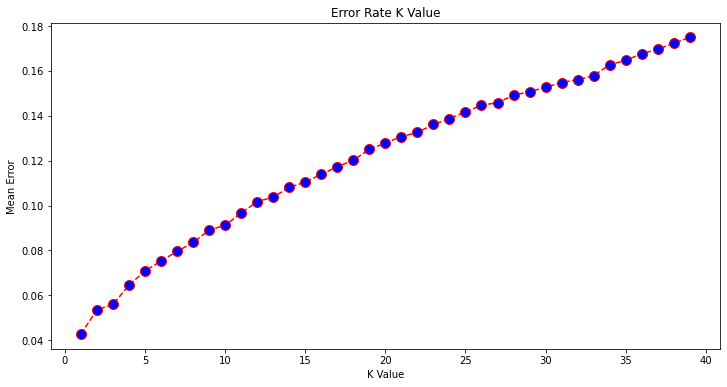

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# 6. Intialize Mediapipe Hands for alphabet recognition.

In [12]:
# Initialize mediapipe hand

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [13]:
# Initialize mediapipe hand capture webcam

cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    max_num_hands = 1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()

        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # Flip the image horizontally for a later selfie-view display, and convert
        # the BGR image to RGB.
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        results = hands.process(image)

        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                coords = hand_landmarks.landmark
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                coords = list(np.array([[landmark.x, landmark.y] for landmark in coords]).flatten())
                coords = scaler.transform([coords])
                
                # Alternative for dataset using z coordinates.
                # Z coordinates is not recommended, since you need to adjust your distance from camera.
#                 coords = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in coords]).flatten())
                
                predicted = classifier.predict(coords)

            # Get status box
            cv2.rectangle(image, (0,0), (100, 60), (245, 90, 16), -1)

            # Display Class
            cv2.putText(image, 'CLASS'
                        , (20,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(predicted[0])
                        , (20,45), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow('MediaPipe Hands', image)

        # Press esc to close webcam
        if cv2.waitKey(5) & 0xFF == 27:
            break
cap.release()
cv2.destroyAllWindows()
